In [1]:
# if our large test file is available, use it. Otherwise, use file generated from toy_mistis_1_setup_run.ipynb
import os
test_file = "../toy_mistis_1k_OPS1.nc"
filename = test_file if os.path.isfile(test_file) else "mistis.nc"

In [2]:
print filename

../toy_mistis_1k_OPS1.nc


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import openpathsampling as paths

In [4]:
%%time
storage = paths.AnalysisStorage(filename)

CPU times: user 5min 6s, sys: 13 s, total: 5min 19s
Wall time: 5min 24s


In [5]:
mistis = storage.networks.load(0)

In [6]:
# this should be true if we restored correctly
for ens in mistis.sampling_transitions[0].ensembles:
    print ens in storage.ensembles[:], repr(ens)

True <openpathsampling.ensemble.TISEnsemble object at 0x14adf15d0>
True <openpathsampling.ensemble.TISEnsemble object at 0x14b764f50>
True <openpathsampling.ensemble.TISEnsemble object at 0x14c283890>
True <openpathsampling.ensemble.TISEnsemble object at 0x14c283d50>
True <openpathsampling.ensemble.TISEnsemble object at 0x14b764710>
True <openpathsampling.ensemble.TISEnsemble object at 0x149f58d10>


In [7]:
mistis.hist_args['max_lambda'] = { 'bin_width' : 0.01, 'bin_range' : (-0.35, 0.5) }
mistis.hist_args['pathlength'] = { 'bin_width' : 5, 'bin_range' : (0, 150) }

In [8]:
scheme = storage.schemes[0]
scheme.move_summary(storage.steps)

pathreversal ran 25.340% (expected 25.38%) of the cycles with acceptance 21227/25340 (83.77%)
ms_outer_shooting ran 2.515% (expected 2.54%) of the cycles with acceptance 1551/2515 (61.67%)
shooting ran 48.273% (expected 48.22%) of the cycles with acceptance 36226/48273 (75.04%)
minus ran 0.974% (expected 1.02%) of the cycles with acceptance 722/974 (74.13%)
repex ran 22.898% (expected 22.84%) of the cycles with acceptance 8332/22898 (36.39%)


In [9]:
scheme.move_summary(storage.steps, 'minus')

Minus ran 0.486% (expected 0.51%) of the cycles with acceptance 236/486 (48.56%)
Minus ran 0.488% (expected 0.51%) of the cycles with acceptance 486/488 (99.59%)


In [10]:
scheme.move_summary(storage.steps, 'repex')

ReplicaExchange ran 1.312% (expected 1.27%) of the cycles with acceptance 725/1312 (55.26%)
ReplicaExchange ran 1.246% (expected 1.27%) of the cycles with acceptance 334/1246 (26.81%)
ReplicaExchange ran 1.280% (expected 1.27%) of the cycles with acceptance 530/1280 (41.41%)
ReplicaExchange ran 1.372% (expected 1.27%) of the cycles with acceptance 269/1372 (19.61%)
ReplicaExchange ran 1.190% (expected 1.27%) of the cycles with acceptance 617/1190 (51.85%)
ReplicaExchange ran 1.274% (expected 1.27%) of the cycles with acceptance 519/1274 (40.74%)
ReplicaExchange ran 1.266% (expected 1.27%) of the cycles with acceptance 280/1266 (22.12%)
ReplicaExchange ran 1.307% (expected 1.27%) of the cycles with acceptance 366/1307 (28.00%)
ReplicaExchange ran 1.225% (expected 1.27%) of the cycles with acceptance 548/1225 (44.73%)
ReplicaExchange ran 1.320% (expected 1.27%) of the cycles with acceptance 550/1320 (41.67%)
ReplicaExchange ran 1.273% (expected 1.27%) of the cycles with acceptance 420/12

In [11]:
# we need to load the states and the innermost interface for each transition
stateA = storage.volumes['A']
stateB = storage.volumes['B']
stateC = storage.volumes['C']
inner_AB = mistis.transitions[(stateA, stateB)].interfaces[0]
inner_AC = mistis.transitions[(stateA, stateC)].interfaces[0]
inner_BA = mistis.transitions[(stateB, stateA)].interfaces[0]

In [12]:
# got these from mistis_flux.ipynb
fluxes = {(stateA, inner_AB): 0.00183239948364,
          (stateA, inner_AC): 0.00183054222139,
          (stateB, inner_BA): 0.00183376505796}
mistis.set_fluxes(fluxes)

In [13]:
%%time
mistis.rate_matrix(storage.steps, force=True)

/Users/dwhs/Dropbox/msm-tis/openpathsampling/numerics/wham.py:334: RuntimeWarning: invalid value encountered in divide
  addends_k = np.divide(numerator_byQ, sum_over_Z_byQ)
/Users/dwhs/Dropbox/msm-tis/openpathsampling/numerics/wham.py:407: RuntimeWarning: invalid value encountered in double_scalars
  output[val] = sum_k_Hk_Q[val] / sum_w_over_Z


CPU times: user 16min 58s, sys: 7.36 s, total: 17min 6s
Wall time: 17min 15s


,B,C,A
B,NaN,NaN,4.57922e-06
A,4.88144e-06,6.03211e-06,NaN


In [14]:
trans = mistis.transitions.values()[2]
trans_hists = trans.histograms['max_lambda']

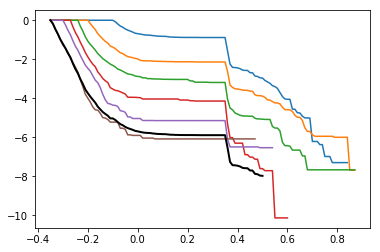

In [15]:
for hist in trans_hists:
    cross_prob = trans_hists[hist].reverse_cumulative()
    plt.plot(cross_prob.x, np.log(cross_prob))
plt.plot(trans.tcp.x, np.log(trans.tcp), '-k', lw=2)

In [16]:
print [str(e.interface) for e in trans_hists.keys()]

['{x|opX(x) in [-inf, -0.1]}', '{x|opX(x) in [-inf, -0.2]}', '{x|opX(x) in [-inf, -0.24]}', '{x|opX(x) in [-inf, -0.27]}', '{x|opX(x) in [-inf, -0.3]}', '{x|opX(x) in [-inf, -0.35]}']


In [17]:
len(storage.steps)

100001

In [3]:
#import logging.config
#logging.config.fileConfig("../resources/debug_logging.conf", disable_existing_loggers=False)

In [4]:
n_blocks = 2  # for testing code

In [ ]:
#! skip
n_blocks = 10 # for real examples

In [19]:
resampling = paths.numerics.BlockResampling(storage.steps, n_blocks=1)

In [20]:
rate_df_func = lambda steps: mistis.rate_matrix(steps, force=True)

In [21]:
%%time
rates = paths.numerics.ResamplingStatistics(function=rate_df_func, inputs=resampling.blocks)

CPU times: user 2min 9s, sys: 1 s, total: 2min 10s
Wall time: 2min 10s


In [22]:
rates.mean

,B,C,A
B,NaN,NaN,6.18014e-06
A,5.32682e-06,9.96266e-06,NaN


In [23]:
rates.std

,B,C,A
B,NaN,NaN,0.000005
A,0.000004,0.000012,NaN


In [24]:
rates.percentile(0)

,B,C,A
B,NaN,NaN,6.30477e-07
A,6.00702e-07,6.38863e-07,NaN


In [25]:
rates.percentile(25)

,B,C,A
B,NaN,NaN,3.83769e-06
A,2.69625e-06,2.04616e-06,NaN


In [26]:
rates.percentile(50)

,B,C,A
B,NaN,NaN,6.15924e-06
A,4.97539e-06,4.75777e-06,NaN


In [27]:
rates.percentile(75)

,B,C,A
B,NaN,NaN,7.6309e-06
A,6.43053e-06,1.12021e-05,NaN


In [28]:
rates.percentile(100)

,B,C,A
B,NaN,NaN,1.82659e-05
A,1.69719e-05,3.85193e-05,NaN
